<a href="https://colab.research.google.com/github/XingxinHE/FinalThesis_DL-GA/blob/master/Pytorch_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.chdir("/content/gdrive/My Drive/Final Thesis/data")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import xgboost as xgb
import seaborn as sns

In [ ]:
dataframe = pd.read_csv('200730_OptionA_8Input_3Ouput_2500Dataset.csv')
#我不习惯用dataframe,用矩阵ndarrays with numpy,每个变量会indexed by an integer, 更方便后续操作
dataset=dataframe.to_numpy()
#scale down the "weight" feature
dataset[:,-2]=dataset[:,-2]/100

In [ ]:
#告诉机器能不能用显卡加速
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


In [ ]:
#one hot encoding from traditional machine learning package sklearn
# 也可以在后面的神经网络里,以一个单独的layer加进去。我在这里做是因为非神经网络模型也会用到one hot, 但用不到batch normalization  
def one_hot(x):
	ohe = OneHotEncoder()
	ohe.fit(x)
	x_enc = ohe.transform(x)
	return x_enc
#只对前四个categorical variables 做 one hot, 直接说明column= 0:4就可以了
#这个function吐出来的是一个稀疏矩阵，所以还要把它转化成正常矩阵
data_one_hot=one_hot(dataset[:,0:4]).toarray()
#把encoding后的矩阵和原始数据后面的变量接起来
data=np.concatenate((data_one_hot,dataset[:,4:]),axis=1)
#把数据转化成float32, 否则后面pytorch无法运行
data=data.astype(np.float32)

In [ ]:
#划分training set, testing set (20%)，可以在这里做数据清洗
#data=dataset
#data=data[filter]
print(data.shape)
#这里用大写X Y代表送入神经网络的torch tensor, 与送入boosting tree的小写 x and y 区分开
#只需要在这里更改random state for different samples
random_state=1
data_split = train_test_split(data[:,:-3], data[:,-3:], test_size=0.2, random_state=random_state)
[x_train,x_test,y_train,y_test]=data_split
#pytorch 不接受ndarray, 所以要把数据转化成pytorch tensor, 还要声明他们可以在GPU上运行
[X_train, X_test, Y_train, Y_test] = map(lambda x:torch.tensor(x).to(device),data_split)


(2552, 23)


In [ ]:
#建立神经网络
class Net(nn.Module):
    def __init__(self,H1,H2,D_out):
        super(Net, self).__init__()
        self.norm_layer=nn.BatchNorm1d(4)
        self.fc1 = nn.Linear(20,H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3=nn.Linear(H2,D_out)
    def forward(self, x):
        #normalization, 我只normalize 最后的四个变量，然后和前面的one hot 接在一起
        norm=self.norm_layer(x[:,16:20])
        x = torch.cat((x[:,:16],norm),dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#你可以更改之前的隐变量，最后一层吐出3个变量，机器会尽量让他们和已知的三个变量接近
net = Net(64,128,3)
net.to(device)
#损失函数
loss_fn = nn.MSELoss()
#学习率，这里优化器用adam
learning_rate = 1e-3
#opt = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
opt = optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
epoch=600
batch_size=400
#batch management for pytorch
train_ds=torch.utils.data.TensorDataset(X_train, Y_train)
train_dl=torch.utils.data.DataLoader(train_ds,batch_size=batch_size,shuffle=True)

test_ds = torch.utils.data.TensorDataset(X_test,Y_test)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size * 2)

In [ ]:
#训练网络， 记录运行时间,实际上因为网络很小，GPU CPU 没差别，
start_time = time.time()
for epoch in range(epoch):
    net.train()
    for x,y in train_dl:
        #take a batch of X and predict their corresponding Y
        pred = net(x)
        # 计算预测值和真实值的mse
        loss = loss_fn(pred,y)
        #pytorch涉及一些自动求导
        loss.backward()
        opt.step()
        opt.zero_grad()
    net.eval()
    with torch.no_grad():
        test_loss = sum(loss_fn(net(x), y) for x,y in test_dl)
    #每训练一百组数据，就打印出模型在testing set上的MSE
    if epoch%100==0:
       print(epoch, test_loss / len(test_dl))
print(epoch, test_loss / len(test_dl))


print("--- %s seconds ---" % (time.time() - start_time))


0 tensor(31885.6074)
100 tensor(5383.8569)
200 tensor(2563.3232)
300 tensor(2478.4163)
400 tensor(2448.8093)
500 tensor(2428.7368)
599 tensor(2381.4941)
--- 16.923535585403442 seconds ---


In [ ]:
##输出神经网络的预测结果： len(test) x 3 的矩阵
predict_neural=net(X_test).detach().numpy()
predict_neural.shape

(511, 3)

In [ ]:
##现在给定参数，建立boosting tree模型
##为三个预测变量，单独拟合三个单独的boosting tree
import xgboost as xgb
def tree (data,random_state):  
    # boosting tree的参数
    param = {'booster': 'gbtree',
            'max_depth': 5, 'learning_rate': 0.3,
            'objective': 'reg:squarederror',
            'eval_metric':'mae' , 'lambda':1,
            }
    pred=[]
    test=[]
    tree_obj=[]
    for i in range(3):
        data_split = train_test_split(data[:,:-3], data[:,(i-3)], test_size=0.2, random_state=random_state)
        [x_train, x_test, y_train, y_test] =data_split
        dtrain = xgb.DMatrix(x_train,label=y_train)
 

        dtest=xgb.DMatrix(x_test,label=y_test)
        evallist = [(dtest, 'eval'), (dtrain, 'train')]

        bst = xgb.train(param, dtrain, early_stopping_rounds=10,evals=evallist,verbose_eval=None)
        pred.append(bst.predict(dtest))
        test.append(y_test)
        tree_obj.append(bst)
    ##输出2个 len(test data) x 3 的矩阵，第i列对应第i个变量的预测值和真实值，,另外输出每个tree object
    return(np.transpose(np.array(pred)),np.transpose(np.array(test)),tree_obj)


In [ ]:
##运行boosting tree模型
predict_tree,y_test,tree_obj=tree(data,random_state)


In [ ]:
##模型评估函数，输出平均绝对值误差，平均绝对值误差与平均误差的比值（即平均有x%的预测误差），以及R square(即模型能解释y%被预测变量的变化)
## x%+y% closes to 1
def regr_metrics(y_test,pred):
    
    mae=sum(np.abs(pred-y_test))/len(pred)
    mae_mean=mae/np.mean(y_test)
    r2=1-np.var(pred-y_test)/np.var(y_test)
    return (mae,mae_mean,r2)

In [ ]:
##打印结果,两种模型基本一致
print("平均绝对值误差， 平均绝对值误差/平均误差， R square")
print("神经网络")
for i in range(3):
  print(regr_metrics(y_test[:,i],predict_neural[:,i]))
print("梯度提升树")
for i in range(3):
  print(regr_metrics(y_test[:,i],predict_tree[:,i]))



平均绝对值误差， 平均绝对值误差/平均误差， R square
神经网络
(1.5684117717402322, 0.45333671152857574, 0.6157956719398499)
(29.02402256706223, 0.12226692841356704, 0.9017465263605118)
(43.8118421326878, 0.4420999245690641, 0.4857413172721863)
梯度提升树
(1.408066582364812, 0.40699023404694723, 0.5956316292285919)
(31.507374966914405, 0.13272832704970788, 0.8734193742275238)
(41.89309571820463, 0.42273808987283984, 0.4744660258293152)


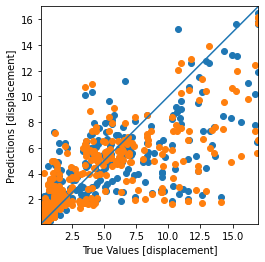

In [ ]:
a=plt.axes(aspect='equal')
plt.scatter(y_test[:,0],predict_neural[:,0])
plt.scatter(y_test[:,0],predict_tree[:,0])
plt.xlabel('True Values [displacement]')
plt.ylabel('Predictions [displacement]')
lims = [min(y_test[:,0]),max(y_test[:,0])]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


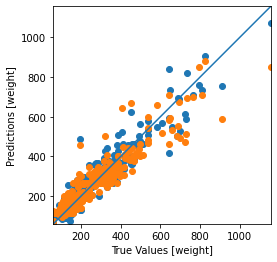

In [ ]:
a=plt.axes(aspect='equal')
plt.scatter(y_test[:,1],predict_neural[:,1])
plt.scatter(y_test[:,1],predict_tree[:,1])
plt.xlabel('True Values [weight]')
plt.ylabel('Predictions [weight]')
lims = [min(y_test[:,1]),max(y_test[:,1])]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

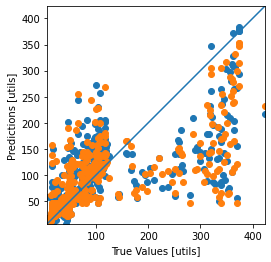

In [ ]:
a=plt.axes(aspect='equal')
plt.scatter(y_test[:,2],predict_neural[:,2])
plt.scatter(y_test[:,2],predict_tree[:,2])
plt.xlabel('True Values [utils]')
plt.ylabel('Predictions [utils]')
lims = [min(y_test[:,2]),max(y_test[:,2])]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

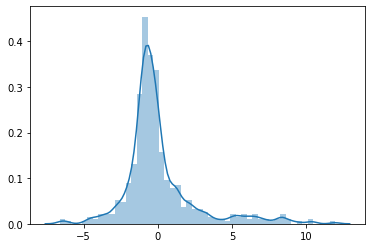

In [ ]:
##误差分布，大部分样本的预测误差接近于零，但在尾部有一些误差非常大
sns.distplot(y_test[:,0]-predict_neural[:,0])

128

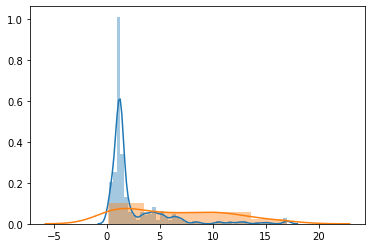

In [ ]:
##有办法三个图plot在一起，但是我没试成功
##I plot the samples with largest 10% predict error in orange, the rest samples in blue
##Then you can see the model cannot predict those samples with true value largely deviated from mean
##Their occurance in the dataset is very small, hence the model is not well trained in that region

error=np.abs(y_test[:,0]-predict_neural[:,0])+np.abs(y_test[:,1]-predict_neural[:,1])+np.abs(y_test[:,2]-predict_neural[:,2])
filter=(error<np.percentile(error,75))

sns.distplot(y_test[filter,0])
sns.distplot(y_test[~filter,0])
np.sum(~filter)

In [ ]:
a=sum(x_test[filter])
b=sum(x_test[~filter])

In [ ]:
a=a/len(x_test[filter])

In [ ]:
b=b/len(x_test[~filter])

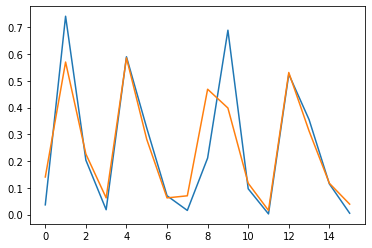

In [ ]:
plt.plot(a[0:16])
plt.plot(b[0:16])

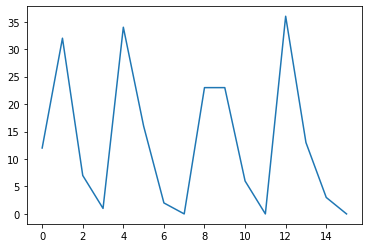

In [ ]:
plt.plot(b[0:16])

In [ ]:
dataframe.head()

,t1,t2,t3,t4,space_a,space_b,space_c,space_d,displacement,weight,util
0,0,2,0,0,758000000.0,200000000.0,422000000.0,326000000.0,8.008692,16751.63525,147.4
1,1,0,2,3,922000000.0,344000000.0,911000000.0,125000000.0,1.739099,66063.55833,57.2
2,3,3,2,3,9630000.0,518000000.0,11300000.0,944000000.0,0.183652,105111.54560,8.2
3,0,1,1,2,609000000.0,390000000.0,718000000.0,703000000.0,9.885369,32353.73617,322.2
4,3,2,2,0,371000000.0,350000000.0,710000000.0,868000000.0,0.992602,49932.30431,23.8


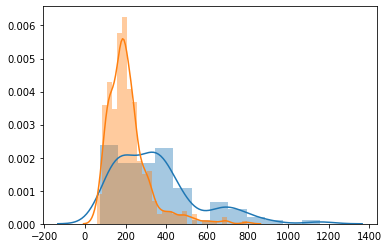

In [ ]:
# same for other predictor variables
error=y_test[:,1]-predict_neural[:,1]
filter=(error<np.percentile(error,10)) | (error>np.percentile(error,90))

sns.distplot(y_test[filter,1])
sns.distplot(y_test[~filter,1])


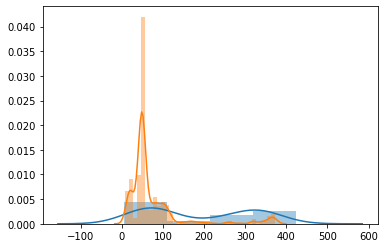

In [ ]:
error=y_test[:,2]-predict_neural[:,2]
filter=(error<np.percentile(error,10)) | (error>np.percentile(error,90))

sns.distplot(y_test[filter,2])
sns.distplot(y_test[~filter,2])
